In [44]:
# Load Module
import torch
import torch.nn as nn
import cv2

In [45]:
filename = '../DATA/angryping.jpg'

In [46]:
img_np = cv2.imread(filename)/255.0
print(img_np.shape, img_np.ndim)

img_np2 = cv2.resize(img_np, (50, 50))
print(img_np2.shape, img_np2.ndim)

gray_np = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)/255.0
gray_np2 = cv2.resize(gray_np, (50, 50))
print(gray_np.shape, gray_np.ndim, '---', gray_np2.shape, gray_np2.ndim)


(535, 473, 3) 3
(50, 50, 3) 3
(535, 473) 2 --- (50, 50) 2


In [47]:
imshow = cv2.imshow('image', img_np2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [48]:
# numpy to tensor
img_tensor = torch.tensor(img_np2, dtype=torch.float32)
gray_tensor = torch.tensor(gray_np2, dtype=torch.float32)
print(img_tensor.shape, img_tensor.ndim, '---', gray_tensor.shape, gray_tensor.ndim)

torch.Size([50, 50, 3]) 3 --- torch.Size([50, 50]) 2


In [49]:
# Pytorch 이미지 데이터 형식 : (C, H, W) -> (H, W, C)
# - permute()
color_hwc = img_tensor.permute(2, 0, 1)
gray_hwc = gray_tensor.unsqueeze(0)
print(color_hwc.shape, color_hwc.ndim, '---', gray_hwc.shape, gray_hwc.ndim)

torch.Size([3, 50, 50]) 3 --- torch.Size([1, 50, 50]) 3


#### CNN Layer 살펴보기

In [50]:
# 이미지 데이터로 conv2D
# 1. 흑백 이미지
con_Layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
# - 커널은 3x3, 이미지 크기는 50x50
#   => (3-1) = 2만큼 짤림; 50x50 => 48x48
#   => (50-3+1) = 48

output = con_Layer(gray_hwc)
print(output.shape)     # torch.Size([1, 48, 48]) => 2만큼 짤린 것을 확인

torch.Size([1, 48, 48])


In [51]:
# out_channels를 8로 변경
con_Layer = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
output = con_Layer(gray_hwc)
print(output.shape)     # torch.Size([8, 48, 48]) => 8개의 채널이 생성됨!!

torch.Size([8, 48, 48])


In [52]:
# conv2D 한 번 더
con_Layer1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
con_Layer2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
print(con_Layer1, con_Layer2, sep='\n')

Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))


In [53]:
# Padding의 차이 확인
con_Layer_p0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
con_Layer_p1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
con_Layer_p2 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=2)
print(con_Layer_p0(gray_hwc).shape, con_Layer_p1(gray_hwc).shape, con_Layer_p2(gray_hwc).shape, sep='\n')
# - torch.Size([8, 48, 48])
# - torch.Size([8, 50, 50])
# - torch.Size([8, 52, 52])

torch.Size([8, 48, 48])
torch.Size([8, 50, 50])
torch.Size([8, 52, 52])


In [54]:
# Kernel : 5x5 이면?
con_Layer_k5 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0)
print(con_Layer_k5(gray_hwc).shape)     
# - torch.Size([8, 46, 46]) : (5-1) 만큼 짤림


torch.Size([8, 46, 46])


In [55]:
# Stride : 2로 변경
con_Layer_s1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0)
con_Layer_s2 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=0)
print(con_Layer_s1(gray_hwc).shape, con_Layer_s2(gray_hwc).shape, sep='\n')
# - torch.Size([8, 48, 48])
# - torch.Size([8, 24, 24]) : 확연히 줆; 시간 단축 및 메모리 효율성 증가
#  => (50-3+1)/1 = 48, stride=2 이면 (50-3+1)/2 = 24

torch.Size([8, 48, 48])
torch.Size([8, 24, 24])


In [61]:
# convXD + AF = F.relu()
from torch.nn.functional import relu

con_Layer_for_pool = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0)
output = con_Layer_for_pool(gray_hwc)

relu_1 = relu(input=output)
print(relu_1.shape)

relu_2 = relu(input=con_Layer2(relu_1))
print(relu_2.shape)

torch.Size([8, 46, 46])
torch.Size([16, 44, 44])


In [56]:
# Pooling
# - Conv에서 추출한 특징을 다운샘플링
# - 결과 : (C, H, W) -> (C, H/2, W/2)

# Max Pooling(kernel=3, stride=1) : 3x3의 영역에서 가장 큰 값만 추출

In [64]:
# 2번째 Conv2D + AF 결과인 피처맵 전달
# MaxPool2d(kernel_size=3, stride=None) : (H-3+1)//3, (W-3+1)//3 = (14, 14)
pool_1 = nn.MaxPool2d(kernel_size=3)    # stride=None : kernel size와 같은 값으로 설정!!!!
fm1 = pool_1(relu_2)
fm1.shape   # (44, 44)를 kernel size 3으로 3x3 영역에서 가장 큰 값만 추출 => 44 // 3 = 14

torch.Size([16, 14, 14])

In [63]:
# MaxPool2d(kernel=3, stride=2) : (H-3)//2 + 1
pool_2 = nn.MaxPool2d(kernel_size=3, stride=2) 
fm2 = pool_2(relu_2)
fm2.shape   # stride = 2 : (44 - 2) // 2 = 21

torch.Size([16, 21, 21])

#### 추출된 피처맵 확인

In [69]:
# 구성 : Conv2D + Conv2D + Pooling
print('gray_hwc : ', gray_hwc.shape)    # torch.Size([1, 50, 50])

con_Layer_k5_1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=1, padding=0)
output1 = relu(con_Layer_k5_1(gray_hwc))    # torch.Size([5, 46, 46]) : in=1, out=5, kernel=5, stride=1, padding=0
print('relu1 : ', output1.shape)

con_Layer_k5_2 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=5, stride=1, padding=0)
output2 = relu(con_Layer_k5_2(output1))     # torch.Size([3, 42, 42]) : in=5, out=3, kernel=5, stride=1, padding=0
print('relu2 : ', output2.shape)

mp1 = pool_1(output2)       # torch.Size([3, 14, 14]) : kernel=3, stride=None
print('mp1 : ', mp1.shape)

gray_hwc :  torch.Size([1, 50, 50])
relu1 :  torch.Size([5, 46, 46])
relu2 :  torch.Size([3, 42, 42])
mp1 :  torch.Size([3, 14, 14])


torch.Size([50, 50])


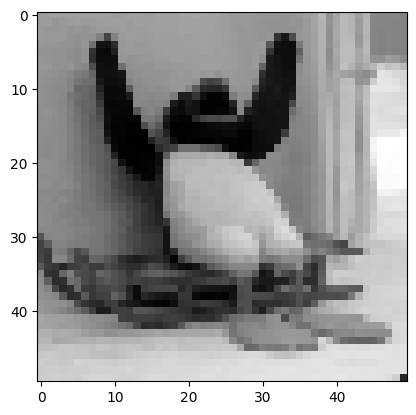

In [71]:
# 시각화
import matplotlib.pyplot as plt

# 3D -> 2D
gray_img = gray_hwc.squeeze(0)
print(gray_img.shape)

# .imshow()
plt.imshow(gray_img, cmap='gray')
plt.show()

torch.Size([46, 46])


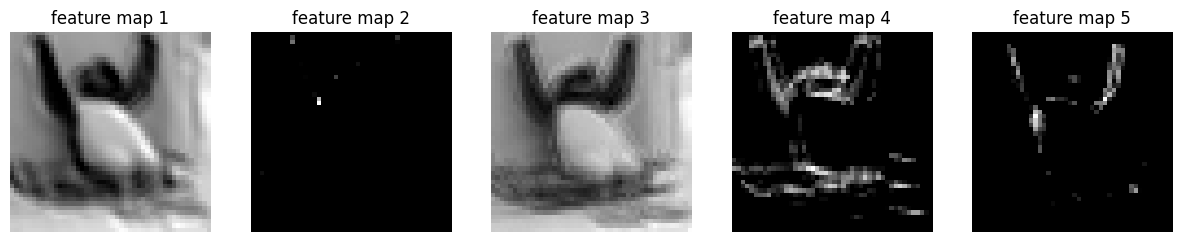

=> conv2d(1, 5, 5, 1, 0) + relu
torch.Size([42, 42])


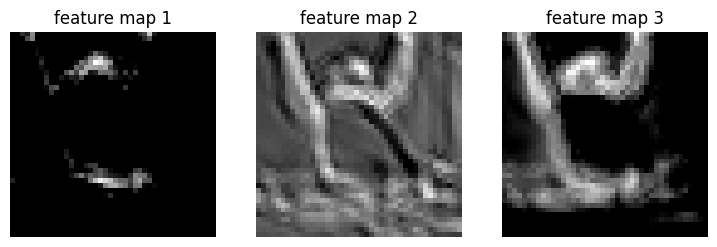

=> conv2d(5, 3, 5, 1, 0) + relu


In [91]:
# 첫 번째 Conv2D Layer 추출 피처맵
def feature_plot(fmap):
    plt.figure(figsize=(len(fmap)*3, 10))
    for idx in range(fmap.shape[0]):
        if idx == 0:
            print(fmap[idx].shape)
        plt.subplot(1, fmap.shape[0], idx+1)
        plt.imshow(fmap[idx].detach().numpy(), cmap='gray')  # .detach() : gradient 계산 없는 tensor로 변환
        plt.title(f'feature map {idx+1}')
        plt.axis('off')
    plt.show()

feature_plot(output1)
print('=> conv2d(1, 5, 5, 1, 0) + relu')
feature_plot(output2)
print('=> conv2d(5, 3, 5, 1, 0) + relu')